In [120]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#### Reading Store level data

In [67]:
store_lvl_df = pd.read_csv('data/sales_forecasting_store_level.csv')

#### Here, Weekly_sales_sum is the target variable that captures the weekly sales of every store. 

In [68]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0


#### Creating a periodic week_nbr column to capture week of the year value between 1 & 52. This column can capture the seasonality by holding the week of the year value

In [69]:
a = []
for el in store_lvl_df.week_nbr:
    if el>52 and el<=104:
        a.append(el-52)
    elif el>104:
        a.append(el-104)
    else:
        a.append(el)
week_nbr_periodic = pd.Series(a)
cols = list(store_lvl_df.columns)
cols.append('week_nbr_periodic')
store_lvl_df = pd.concat([store_lvl_df, week_nbr_periodic], axis = 1)
store_lvl_df.columns = cols

In [72]:
### Vary from Weeks 1 to 52 & repeat
print(store_lvl_df.columns)
print(store_lvl_df.week_nbr_periodic.unique())

Index(['Weekly_Sales_sum', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'week_nbr', 'Size', 'Type_A', 'Type_B',
       'Type_C', 'week_nbr_periodic'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [74]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


In [80]:
type(store_lvl_df.IsHoliday[0])

numpy.bool_

## APPROACH EXPERIMENT 1: Train 45 Linear Regression Models for each of the 45 stores using 5 lagged Moving Window 
##### (Treating as Time Series data by using the previous 5 week sales as inputs)

We are going to train a seperate linear regression model for every store by using 5 previous week sales values as input along with other existing input attributes such as Temperature, Fuel_Price, CPI, Unemployment & IsHoliday.
We are training a seperate model for each store because the time series sales trend varies from store to store and hence, in order to make accurate forecasts by capturing the unique trend for each store, we are experimenting with this approach.
Also, since we are using moving window with lag of 5, where 5 previous output values are provided as input, we will have to train a seperate linear regression model for each store.

##### Creating a dictionary of 90 dataframes (Train & Test DF) for the 45 stores

In [163]:
%%capture
stores_dict = {}   ### Creating a dictionary containing the 45 stores
no_lags = 5  ### Moving Window approach - number of lagged previous sales values

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
    
    Sales_lag1=store.Weekly_Sales_sum.shift(1)    ### Creating 5 series with lagged values of sales
    Sales_lag2=store.Weekly_Sales_sum.shift(2)
    Sales_lag3=store.Weekly_Sales_sum.shift(3)
    Sales_lag4=store.Weekly_Sales_sum.shift(4)
    Sales_lag5=store.Weekly_Sales_sum.shift(5)
        
    store_cols = list(store.columns)
    for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']:
        store_cols.append(el)
        
    ### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
    store = pd.concat([store, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5], axis=1).dropna()
    store.columns = store_cols
    
    store = store.drop(columns=['Date'])
    
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])
    store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']] = scaler.transform(store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])
    store_test[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']] = scaler.transform(store_test[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])
    
    ### APPENDING Store Train & Test DF to dictionary
    stores_dict["store_{}_train".format(i)] = store_train
    stores_dict["store_{}_test".format(i)] = store_test

In [164]:
len(stores_dict)

90

In [166]:
stores_dict['store_1_test'].head()

,Weekly_Sales_sum,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5
105,0.460892,1,0.224356,0.628912,1.009473,0.0,True,106,0.0,1,0,0,2,1638471.02,1325505.30,1400681.26,1470916.08,1551853.40
106,0.453363,1,0.176356,0.704173,1.025801,0.0,False,107,0.0,1,0,0,3,1803715.13,1638471.02,1325505.30,1400681.26,1470916.08
107,0.212170,1,0.388444,0.737705,1.047271,0.0,False,108,0.0,1,0,0,4,1795903.16,1803715.13,1638471.02,1325505.30,1400681.26
108,0.351720,1,0.454400,0.793592,1.068740,0.0,False,109,0.0,1,0,0,5,1545647.93,1795903.16,1803715.13,1638471.02,1325505.30
109,0.349063,1,0.415289,0.822653,1.090210,0.0,False,110,0.0,1,0,0,6,1690441.27,1545647.93,1795903.16,1803715.13,1638471.02


In [167]:
stores_dict['store_2_train'].head()

,Weekly_Sales_sum,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5
148,0.195815,2,0.406830,0.076006,0.105885,1.000000,False,6,0.0,1,0,0,6,1990703.35,1865273.03,2125976.54,2136793.52,2138513.88
149,0.171541,2,0.356432,0.115499,0.089151,1.000000,False,7,0.0,1,0,0,7,1989480.28,1990703.35,1865273.03,2125976.54,2136793.52
150,0.057894,2,0.302387,0.124441,0.069104,1.000000,False,8,0.0,1,0,0,8,1947186.02,1989480.28,1990703.35,1865273.03,2125976.54
151,0.240108,2,0.501492,0.114754,0.049058,0.902131,False,9,0.0,1,0,0,9,1749168.31,1947186.02,1989480.28,1990703.35,1865273.03
152,0.175929,2,0.536969,0.152757,0.029012,0.902131,False,10,0.0,1,0,0,10,2066656.72,1749168.31,1947186.02,1989480.28,1990703.35


### 1. A. Fitting Regression Model for each store on Train Data using all the input attributes

In [94]:
mse_train = []
mse_test = []
Y_pred_train_lst = []
Y_pred_test_lst = []
for i in range(1,int(len(stores_dict)/2)+1):
    df_train = stores_dict["store_{}_train".format(i)]
    df_test = stores_dict["store_{}_test".format(i)]
    ### SPLITTING into X Train & X Test
    df_x_train = df_train[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_train = df_train['Weekly_Sales_sum']
    
    df_x_test = df_test[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_test = df_test['Weekly_Sales_sum']
    
    ### FIT the Linear Regression model
    reg = LinearRegression().fit(df_x_train, y_train)
    
    ### Make Predictions on Train & Test data
    Y_pred_test = reg.predict(df_x_test)
    Y_pred_train = reg.predict(df_x_train)
    
    ### Append Predictions of each store into a list
    Y_pred_train_lst.append(Y_pred_train)
    Y_pred_test_lst.append(Y_pred_test)
    
    ### Append Train & Test MSE values of each store into a list
    mse_train.append(mean_squared_error(y_train, Y_pred_train))
    mse_test.append(mean_squared_error(y_test, Y_pred_test))

#### Average Test MSE across all 45 stores

In [100]:
sum(mse_test)/len(mse_test)

0.011963569232514829

#### Average Train MSE across all 45 stores
The Train & Test MSE are in line and the overall MSE using the Linear Regression approach is obtained by calculating the average of MSEs obtained on the predictions made for each store.

In [101]:
sum(mse_train)/len(mse_train)

0.01509561302152208

##### The stores 20 & 4 are the top 2 stores, with highest sales

In [145]:
store_agg_df = store_lvl_df.groupby(['Store'],as_index=False).agg({'Weekly_Sales_sum': ['sum']})
store_agg_df.columns = ["_".join(x) for x in store_agg_df.columns.ravel()]
store_agg_df = store_agg_df.sort_values(['Weekly_Sales_sum_sum'], ascending=[False])
store_agg_df.head(2)

,Store_,Weekly_Sales_sum_sum
19,20,3.013978e+08
3,4,2.995440e+08


### Plotting Actual Vs Predicted for the Train Data of Store Number 20 (Top store 1)

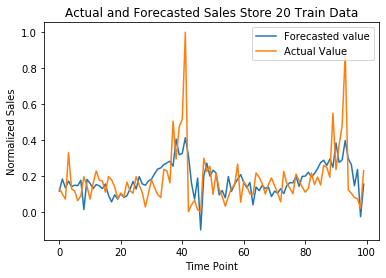

In [146]:
time_point = [el for el in range(0,100)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_train_lst[19])
ax1.plot(time_point, list(stores_dict["store_20_train"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 20 Train Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Test Data of Store Number 20

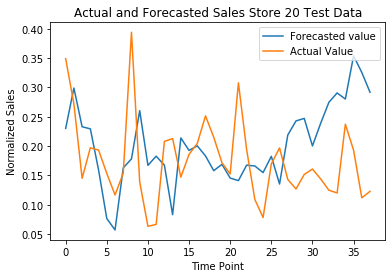

In [147]:
time_point = [el for el in range(0,38)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_test_lst[19])  ### 19th index in a list indexed from 0 to 44
ax1.plot(time_point, list(stores_dict["store_20_test"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 20 Test Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Train Data of Store Number 4 (Top store 2)

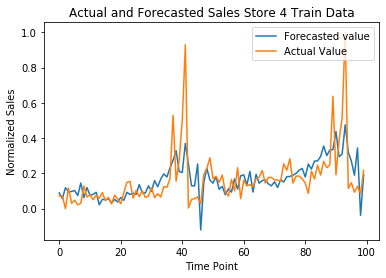

In [149]:
time_point = [el for el in range(0,100)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_train_lst[3])
ax1.plot(time_point, list(stores_dict["store_4_train"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 4 Train Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Test Data of Store Number 4

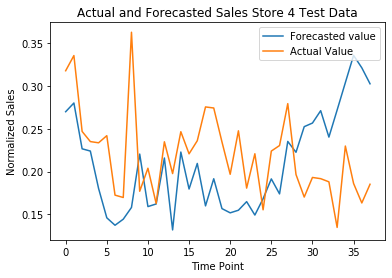

In [150]:
time_point = [el for el in range(0,38)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_test_lst[3])
ax1.plot(time_point, list(stores_dict["store_4_test"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 4 Test Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### 1. B. Fitting Regression Model for each store on Train Data using only 'week_nbr_periodic', 'IsHoliday' & the lag attributes

In [156]:
mse_train2 = []
mse_test2 = []
Y_pred_train_lst2 = []
Y_pred_test_lst2 = []
for i in range(1,int(len(stores_dict)/2)+1):
    df_train = stores_dict["store_{}_train".format(i)]
    df_test = stores_dict["store_{}_test".format(i)]
    ### SPLITTING into X Train & X Test
    df_x_train = df_train[['IsHoliday','week_nbr_periodic','Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_train = df_train['Weekly_Sales_sum']
    
    df_x_test = df_test[['IsHoliday','week_nbr_periodic','Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_test = df_test['Weekly_Sales_sum']
    
    ### FIT the Linear Regression model
    reg = LinearRegression().fit(df_x_train, y_train)
    
    ### Make Predictions on Train & Test data
    Y_pred_test = reg.predict(df_x_test)
    Y_pred_train = reg.predict(df_x_train)
    
    ### Append Predictions of each store into a list
    Y_pred_train_lst2.append(Y_pred_train)
    Y_pred_test_lst2.append(Y_pred_test)
    
    ### Append Train & Test MSE values of each store into a list
    mse_train2.append(mean_squared_error(y_train, Y_pred_train))
    mse_test2.append(mean_squared_error(y_test, Y_pred_test))

#### Average Test MSE across all 45 stores

In [157]:
sum(mse_test2)/len(mse_test2)

0.007985563304522873

#### Average Train MSE across all 45 stores

In [158]:
sum(mse_train2)/len(mse_train2)

0.016424650127597994

### Plotting Actual Vs Predicted for the Train Data of Store Number 20

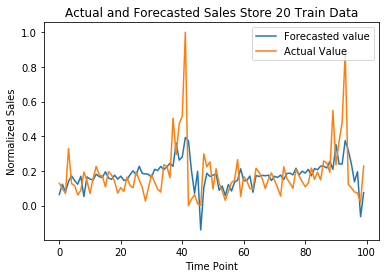

In [159]:
time_point = [el for el in range(0,100)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_train_lst2[19])
ax1.plot(time_point, list(stores_dict["store_20_train"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 20 Train Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Test Data of Store Number 20

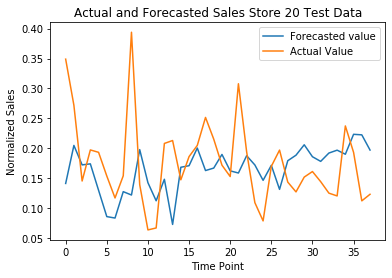

In [160]:
time_point = [el for el in range(0,38)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_test_lst2[19])
ax1.plot(time_point, list(stores_dict["store_20_test"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 20 Test Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Train Data of Store Number 4

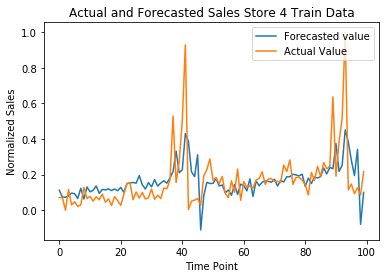

In [161]:
time_point = [el for el in range(0,100)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_train_lst2[3])
ax1.plot(time_point, list(stores_dict["store_4_train"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 4 Train Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

### Plotting Actual Vs Predicted for the Test Data of Store Number 4

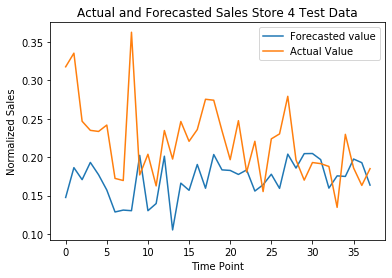

In [162]:
time_point = [el for el in range(0,38)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, Y_pred_test_lst2[3])
ax1.plot(time_point, list(stores_dict["store_4_test"]["Weekly_Sales_sum"]))
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Sales Store 4 Test Data')
plt.xlabel('Time Point')
plt.ylabel('Normalized Sales')
plt.show()

#### Conclusion: We can observe that the linear regression model built is not able to accurately forecast the seasonal drastic peaks and dips in sales. For example the actual sales value for both stores 20 & store 4 are peaking to a very high value around the holiday weeks of 40, while the model is not able to forecast the same peak. 

## APPROACH EXPERIMENT 2: Train One single Linear Regression Model

In the approach, the time series aspect is not taken into consideration and the moving window technique is not used. The characteristics of a store ('store type', 'store size'), other external characteristics ('Temperature','Fuel_Price','CPI','Unemployment','IsHoliday') along with week of the year ('week_nbr_periodic') columns are used as input attributes to make the predictions. This is implemented by treating the dataset as a regular function approximation problem data instead of a time series dataset (not using moving window lags & not training seperate model for every store). Hence a single Linear Regression model is trained on the entire dataset which is common for all the stores. 